# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

#### Подключаем Google Drive и задаём корневую папку проекта

In [1]:
#  ===== 0. Подключаем Google Drive и задаём корневую папку проекта =====
from pathlib import Path
import sys, os

try:
    # вариант Colab
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_ROOT = Path("/content/drive/MyDrive")
except (ModuleNotFoundError, ValueError):
    # локальный Jupyter + Google Drive for desktop
    #   (проверьте, где именно у вас смонтирован «Мой Диск»)
    possible = [
        Path.home() / "Google Drive",
        Path.home() / "Мой диск"            # рус. версия клиента
    ]
    GDRIVE_ROOT = next((p for p in possible if p.exists()), None)
    if GDRIVE_ROOT is None:
        sys.exit("Папка Google Drive не найдена. Проверьте путь.")

# ────────────────────────────────────────────────────────────────────────
PROJECT_DIR = GDRIVE_ROOT / "price_forecasting"
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Единая «точка входа» для остальных путей
ROOT                     = PROJECT_DIR
DATA                     = ROOT / "data"               # сырые и промежуточные датасеты
RAW                      = DATA / "raw"
DATA_PREPARATION         = DATA / "data_preparation"
EDA_AND_FEATURE_ANALYSIS = DATA / "eda_and_feature_analysis"
ARTIFACTS                = ROOT / "artifacts"          # модели, метрики, изображения
PLOTS                    = ARTIFACTS / "plots"

for d in (DATA, RAW, DATA_PREPARATION, EDA_AND_FEATURE_ANALYSIS, ARTIFACTS, PLOTS):
    d.mkdir(parents=True, exist_ok=True)

print(f"Все файлы читаем/пишем в: {ROOT}")


Mounted at /content/drive
Все файлы читаем/пишем в: /content/drive/MyDrive/price_forecasting


### Шаг 1: Загрузка датасета и общая информация

In [2]:
# Шаг 1: Загрузка датасета
# Цель: Загрузить финальный датасет с логарифмом цен, календарными и категориальными признаками для EDA.

import pandas as pd
import os

# Путь к датасету
data_path = DATA_PREPARATION / 'data_preparation.parquet'

# Загрузка датасета
df = pd.read_parquet(data_path)

In [3]:
# Просмотр первых строк и структуры таблицы
display(df.head(5))
display(df.info())
display(df.describe(include='all'))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk_x,sell_price,...,rolling_std_14,rolling_mean_28,rolling_mean_56,rolling_mean_365,rolling_min_365,price_max_365,price_norm,price_momentum_7,price_pct_change_7,is_discounted
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,9.58,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,11101,0.70,...,0.0,0.0,0.0,0.0,0.0,9.58,1.000000,NaN,NaN,0
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,11101,0.57,...,0.0,0.0,0.0,0.0,0.0,9.58,0.073069,NaN,NaN,1
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,11101,0.48,...,0.0,0.0,0.0,0.0,0.0,9.58,0.059499,NaN,NaN,1
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,11101,4.88,...,0.0,0.0,0.0,0.0,0.0,9.58,0.050104,NaN,NaN,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 39 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  category      
 1   item_id             category      
 2   dept_id             category      
 3   cat_id              category      
 4   store_id            category      
 5   state_id            category      
 6   d                   object        
 7   sales               int16         
 8   wm_yr_wk_x          int16         
 9   sell_price          float32       
 10  date                datetime64[ns]
 11  wm_yr_wk_y          int16         
 12  weekday             category      
 13  wday                int8          
 14  month               int8          
 15  year                int16         
 16  event_name_1        category      
 17  event_type_1        category      
 18  event_name_2        category      
 19  event_type_2        category      
 20  

None

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk_x,sell_price,...,rolling_std_14,rolling_mean_28,rolling_mean_56,rolling_mean_365,rolling_min_365,price_max_365,price_norm,price_momentum_7,price_pct_change_7,is_discounted
count,58327370,58327370,58327370,58327370,58327370,58327370,58327370,5.832737e+07,5.832737e+07,5.832737e+07,...,5.832737e+07,5.829688e+07,5.832737e+07,5.832737e+07,5.832737e+07,5.829688e+07,5.829688e+07,5.808345e+07,5.808345e+07,5.832737e+07
unique,30490,3049,7,3,10,3,1913,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,CA_1,CA,d_1913,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1913,19130,15743990,27489810,5832737,23330948,30490,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.126322e+00,1.133919e+04,4.446165e+00,...,9.632273e-01,1.122878e+00,1.118638e+00,1.081355e+00,6.760240e-03,2.519770e+01,1.850486e-01,-1.494374e-02,7.455985e-01,9.920448e-01
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.110100e+04,1.000000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e-01,3.227889e-04,-9.965000e+01,-9.996662e-01,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.121700e+04,2.180000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.383562e-02,0.000000e+00,1.998000e+01,8.632597e-02,-2.090000e+00,-4.680135e-01,1.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.133300e+04,3.420000e+00,...,5.345225e-01,3.214286e-01,3.214286e-01,3.369863e-01,0.000000e+00,2.698000e+01,1.380078e-01,0.000000e+00,0.000000e+00,1.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.144800e+04,5.840000e+00,...,1.176697e+00,1.035714e+00,1.035714e+00,1.002740e+00,0.000000e+00,2.997000e+01,2.325659e-01,2.070000e+00,9.143468e-01,1.000000e+00
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.630000e+02,1.161300e+04,1.073200e+02,...,2.110041e+02,4.427500e+02,3.980000e+02,3.980000e+02,3.600000e+02,1.073200e+02,1.000000e+00,1.025500e+02,1.747000e+03,1.000000e+00


#### Шаг 1: Загрузка объединённого датасета — выводы

- Загрузился датасет на **58+ миллионов строк** и **39 колонок**.
- Данные включают как **продажи**, так и **цены**, календарные признаки, лаги и скользящие окна.
- Целевая переменная `sell_price` присутствует, а также её производные (`price_norm`, `price_momentum_7`, `price_pct_change_7` и др.).
- Есть пропуски (например, в `rolling_mean_28`), что потребует дополнительной обработки на этапе обучения моделей.
- Оптимизированные типы данных (`category`, `int8`, `float32`) позволяют экономно работать с объёмом в ~5.8 GB.


### Шаг 2: Добавление логарифма цены и анализ распределения целевой переменной

In [4]:
# Шаг 2: Добавление логарифма цены и анализ распределения целевой переменной
# Цель: Создать две версии таргета (сырую и логарифмическую) и построить гистограммы их распределения
# для оценки формы, хвостов и пригодности для различных типов моделей.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import gc

# Создание переменных-таргетов
df["y_raw"] = df["sell_price"]
df["y_log"] = np.log1p(df["y_raw"])  # log(1 + price)

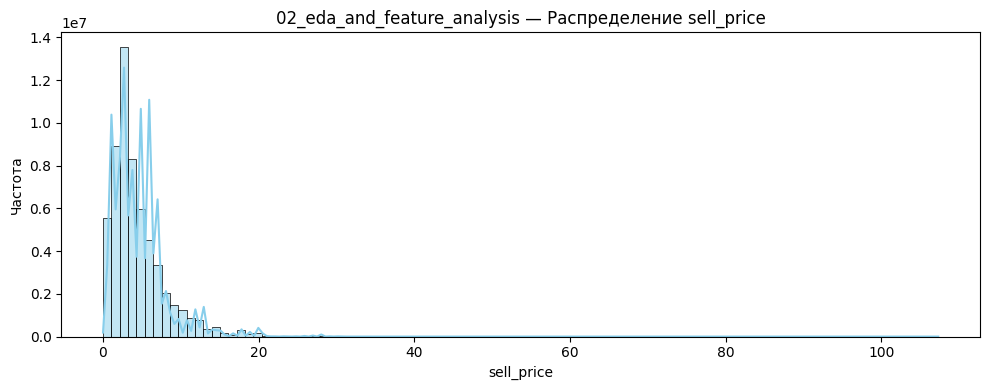

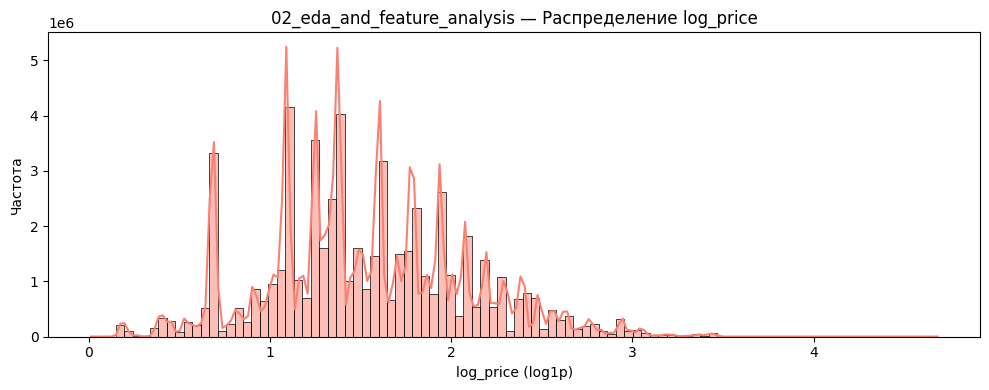

8506

In [5]:
# Создание директории для сохранения графиков
os.makedirs("../data/plots", exist_ok=True)

# --- График распределения исходной цены ---
plt.figure(figsize=(10, 4))
sns.histplot(df["y_raw"], bins=100, kde=True, color='skyblue')
plt.title("02_eda_and_feature_analysis — Распределение sell_price")
plt.xlabel("sell_price")
plt.ylabel("Частота")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_y_raw_dist.png")
plt.show()
plt.close()

# Очистка памяти после первого графика
gc.collect()

# --- График распределения логарифма цены ---
plt.figure(figsize=(10, 4))
sns.histplot(df["y_log"], bins=100, kde=True, color='salmon')
plt.title("02_eda_and_feature_analysis — Распределение log_price")
plt.xlabel("log_price (log1p)")
plt.ylabel("Частота")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_y_log_dist.png")
plt.show()
plt.close()

# Очистка памяти после второго графика
gc.collect()


#### Шаг 2: Анализ распределения целевой переменной — выводы

- Распределение `sell_price` сильно **смещено вправо** — это типично для цен в ритейле: много недорогих товаров и редкие "пики" выше $50.
- Логарифмическое преобразование `log_price = log1p(sell_price)` значительно **сглаживает хвосты** и приближает распределение к нормальному.
- Это важно, потому что:
  - **Лог-цены** предпочтительны для моделей, чувствительных к масштабам и выбросам (линейная регрессия, ARIMA, нейросети).
  - **Исходные цены** (`sell_price`) лучше подходят для деревьев и бустинга (XGBoost, LightGBM), которые устойчивы к масштабу и выбросам.
- Поэтому мы сразу сохраняем две версии целевой переменной:
  - `y_raw = sell_price`
  - `y_log = log1p(sell_price)`

Это обеспечит гибкость при обучении и сравнении различных моделей на следующих этапах.


### Шаг 3: Построение QQ-плотов для оценки нормальности распределения

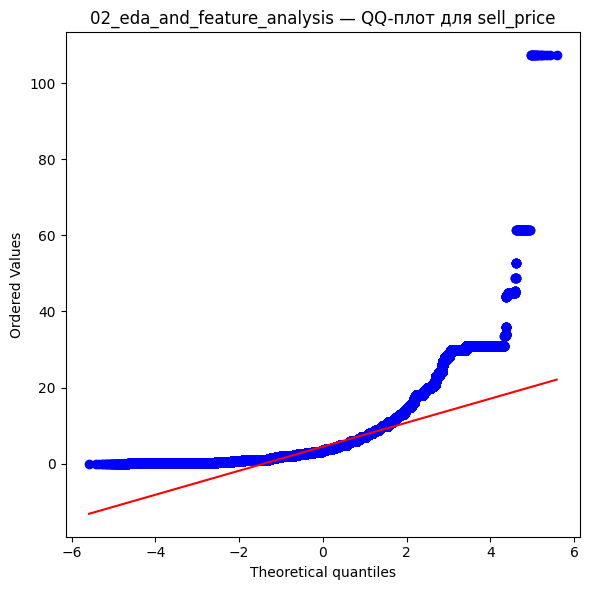

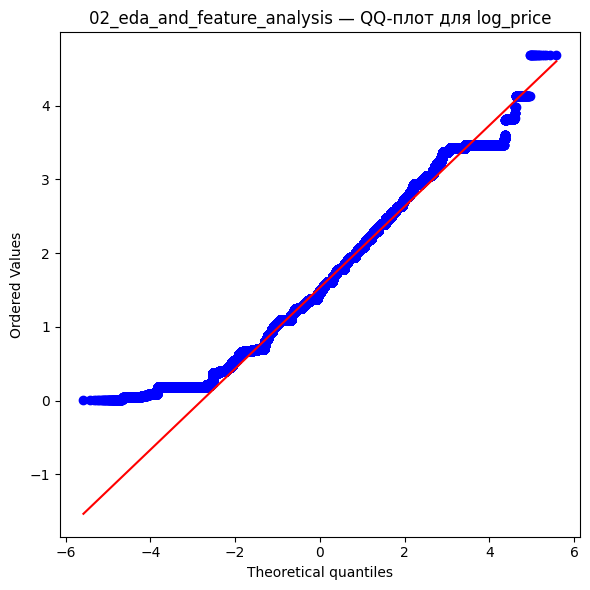

3242

In [6]:
# Шаг 3: Построение QQ-плотов для оценки нормальности распределения
# Цель: Сравнить поведение распределения исходной цены и её логарифма с нормальным распределением
# с помощью графиков квантиль-квантиль (QQ-плотов). Это помогает обосновать, что log_price ближе к нормальному.

import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import gc

# --- QQ-плот для sell_price (y_raw) ---
plt.figure(figsize=(6, 6))
stats.probplot(df["y_raw"].dropna(), dist="norm", plot=plt)
plt.title("02_eda_and_feature_analysis — QQ-плот для sell_price")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_qq_y_raw.png")
plt.show()
plt.close()
gc.collect()

# --- QQ-плот для log_price (y_log) ---
plt.figure(figsize=(6, 6))
stats.probplot(df["y_log"].dropna(), dist="norm", plot=plt)
plt.title("02_eda_and_feature_analysis — QQ-плот для log_price")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_qq_y_log.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 3: QQ-плоты — проверка нормальности целевой переменной

- QQ-плот для `sell_price` показывает выраженное отклонение от нормального распределения:
  - сильная правосторонняя асимметрия;
  - высокие значения ("пики") заметно отходят от теоретической линии.

- Для `log_price` ситуация значительно лучше:
  - большинство точек лежат вдоль прямой;
  - хвосты сглажены, выбросы значительно менее выражены.

Это подтверждает, что логарифмическое преобразование делает распределение ближе к нормальному и может улучшить работу моделей, чувствительных к форме распределения (например, линейных моделей, MSE-базированных нейросетей).

Оставим в пайплайне обе версии целевой переменной (`y_raw` и `y_log`), чтобы сравнивать их влияние на различные модели.


### Шаг 4: Boxplot цен и лог-цен по магазинам и категориям

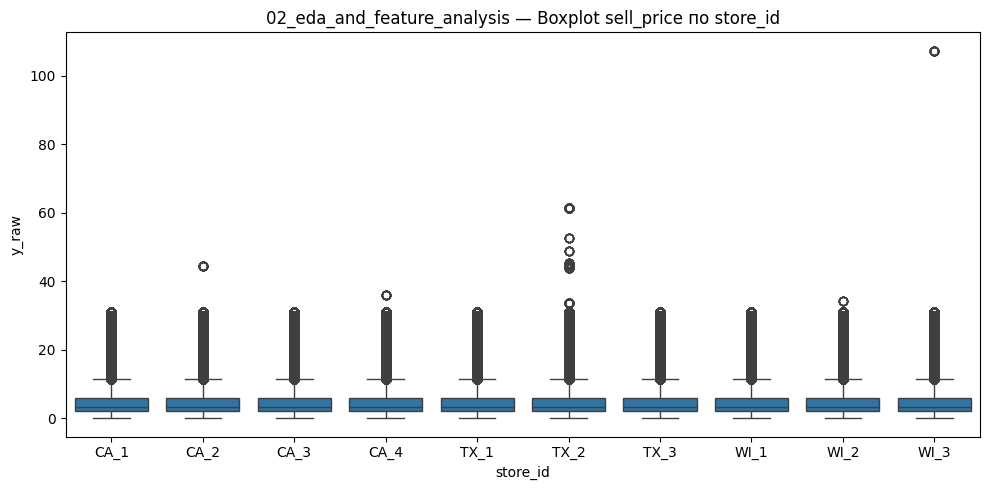

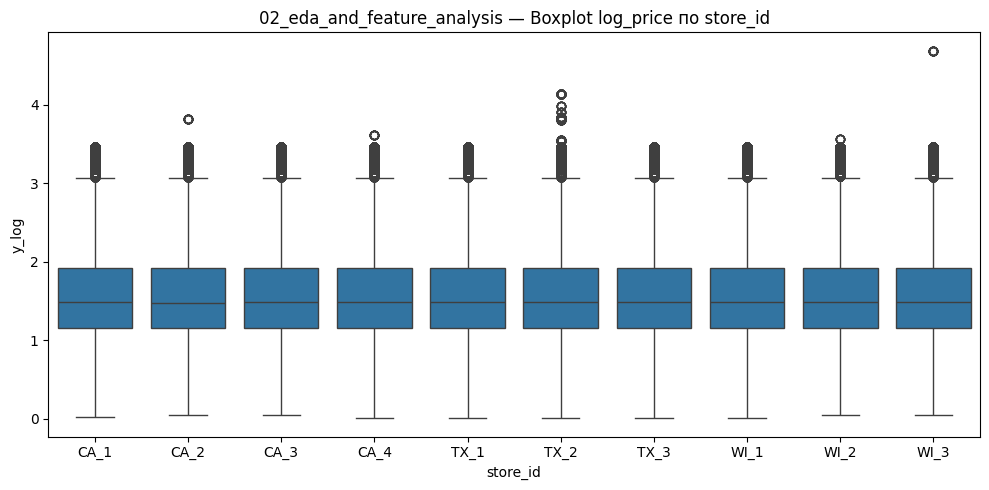

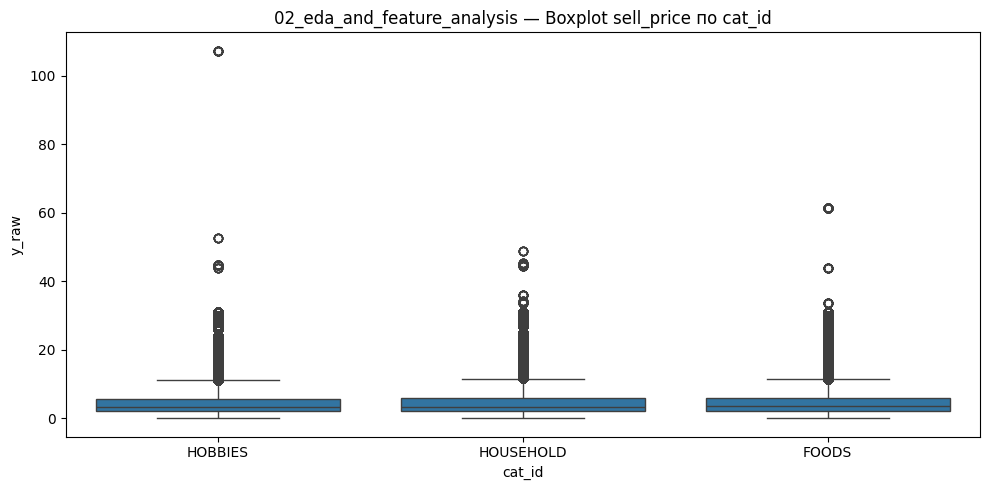

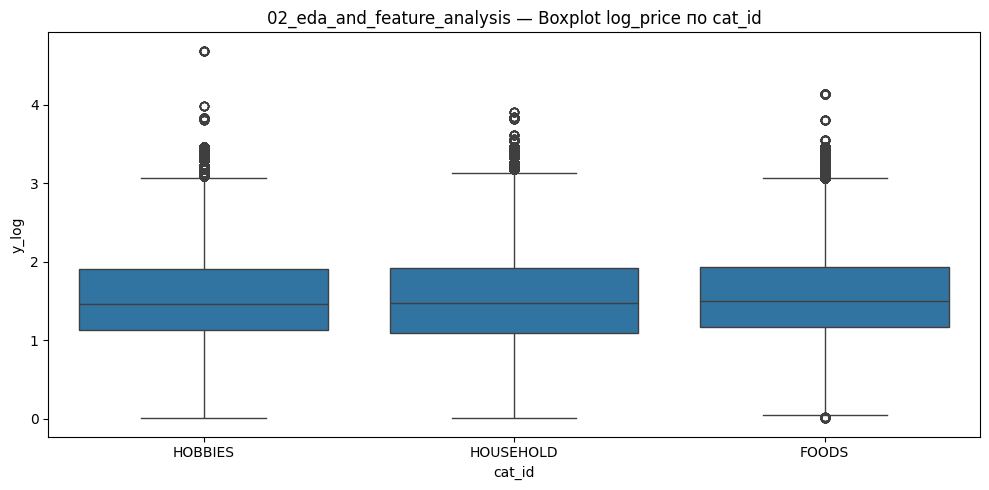

3874

In [7]:
# Шаг 4: Boxplot цен и лог-цен по магазинам и категориям
# Цель: Сравнить распределения цен и логарифма цен между разными магазинами и категориями.
# Это позволяет увидеть различия в масштабах, выбросах и структуре по сегментам.

import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

# --- Boxplot: sell_price по store_id ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="store_id", y="y_raw")
plt.title("02_eda_and_feature_analysis — Boxplot sell_price по store_id")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_boxplot_y_raw_by_store.png")
plt.show()
plt.close()
gc.collect()

# --- Boxplot: log_price по store_id ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="store_id", y="y_log")
plt.title("02_eda_and_feature_analysis — Boxplot log_price по store_id")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_boxplot_y_log_by_store.png")
plt.show()
plt.close()
gc.collect()

# --- Boxplot: sell_price по cat_id ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="cat_id", y="y_raw")
plt.title("02_eda_and_feature_analysis — Boxplot sell_price по cat_id")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_boxplot_y_raw_by_cat.png")
plt.show()
plt.close()
gc.collect()

# --- Boxplot: log_price по cat_id ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="cat_id", y="y_log")
plt.title("02_eda_and_feature_analysis — Boxplot log_price по cat_id")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_boxplot_y_log_by_cat.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 4: Boxplot цен по магазинам и категориям — выводы

- Распределения `sell_price` по магазинам (`store_id`) заметно различаются по масштабам и количеству выбросов:
  - Некоторые магазины (например, TX_2 и WI_3) имеют более высокие выбросы.
  - Основная масса цен находится в диапазоне до $10.

- Логарифмирование (график `log_price`) существенно **сглаживает различия** между магазинами:
  - Ящики (межквартильный диапазон) становятся визуально ближе по масштабу.
  - Выбросы становятся менее экстремальными.

- Аналогичная картина наблюдается и по категориям (`cat_id`):
  - В сыром виде категории **FOODS** и **HOUSEHOLD** содержат аномально высокие значения.
  - После лог-преобразования — распределения становятся более симметричными и сопоставимыми между категориями.

Эти графики подтверждают, что логарифмирование полезно не только для глобального распределения, но и для **снижения дисбаланса между сегментами**. Это улучшает стабильность моделей, особенно при работе с категориальными признаками.


### Шаг 5: Анализ сезонности цен по времени

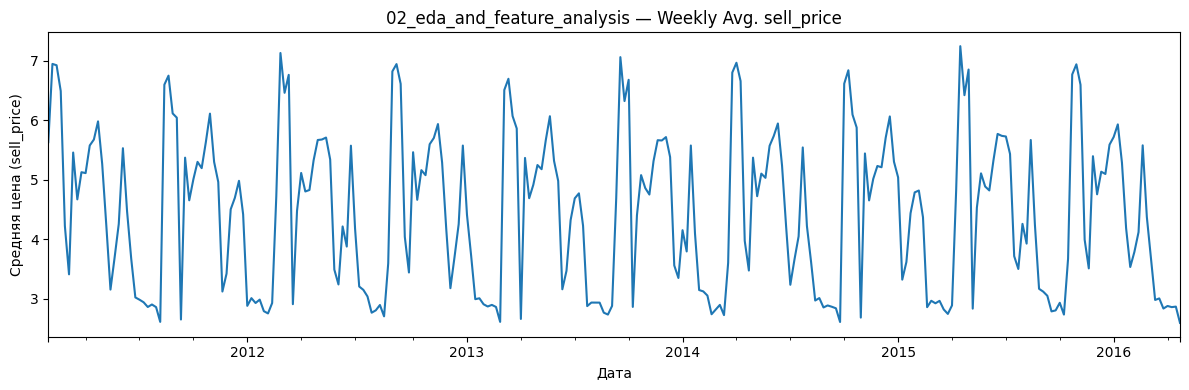

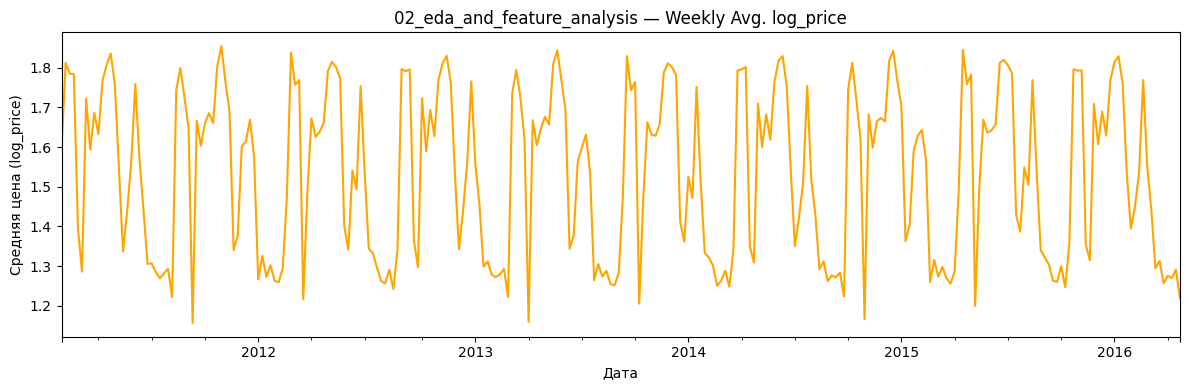

4744

In [8]:
# Шаг 5: Анализ сезонности цен по времени
# Цель: Построить график средней цены по неделям, чтобы выявить инфляционные тренды и годовые циклы.

import matplotlib.pyplot as plt
import os
import gc

# Убедимся, что 'date' в индексе для ресемплинга
df_time = df[["date", "y_raw", "y_log"]].copy()
df_time = df_time.set_index("date")

# Агрегация: средняя цена по неделям
weekly_prices = df_time.resample("W").mean()

# --- График средней sell_price во времени ---
plt.figure(figsize=(12, 4))
weekly_prices["y_raw"].plot()
plt.title("02_eda_and_feature_analysis — Weekly Avg. sell_price")
plt.ylabel("Средняя цена (sell_price)")
plt.xlabel("Дата")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_seasonality_y_raw.png")
plt.show()
plt.close()
gc.collect()

# --- График средней log_price во времени ---
plt.figure(figsize=(12, 4))
weekly_prices["y_log"].plot(color='orange')
plt.title("02_eda_and_feature_analysis — Weekly Avg. log_price")
plt.ylabel("Средняя цена (log_price)")
plt.xlabel("Дата")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_seasonality_y_log.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 5: Анализ сезонности цен — выводы

- Наблюдается **чётко выраженная годовая сезонность**: резкие всплески цен происходят регулярно, примерно в одно и то же время года.
- Такие пики, вероятно, связаны с крупными распродажами (например, Black Friday, рождественский сезон) или маркетинговыми циклами.
- Уровень цен в логарифмической шкале (`log_price`) также сохраняет сезонную структуру, но становится **менее чувствителен к экстремальным значениям** и выглядит сглаженным.
- Инфляционного тренда за 5 лет явно не наблюдается — средняя цена остаётся в стабильном диапазоне.

Важно:
- для обоснования использования временных признаков (неделя, месяц, праздники и т.д.);
- для выбора моделей с поддержкой сезонности (Prophet, Holt-Winters, RNN, TFT и т.д.).


In [11]:
!pip install statsmodels

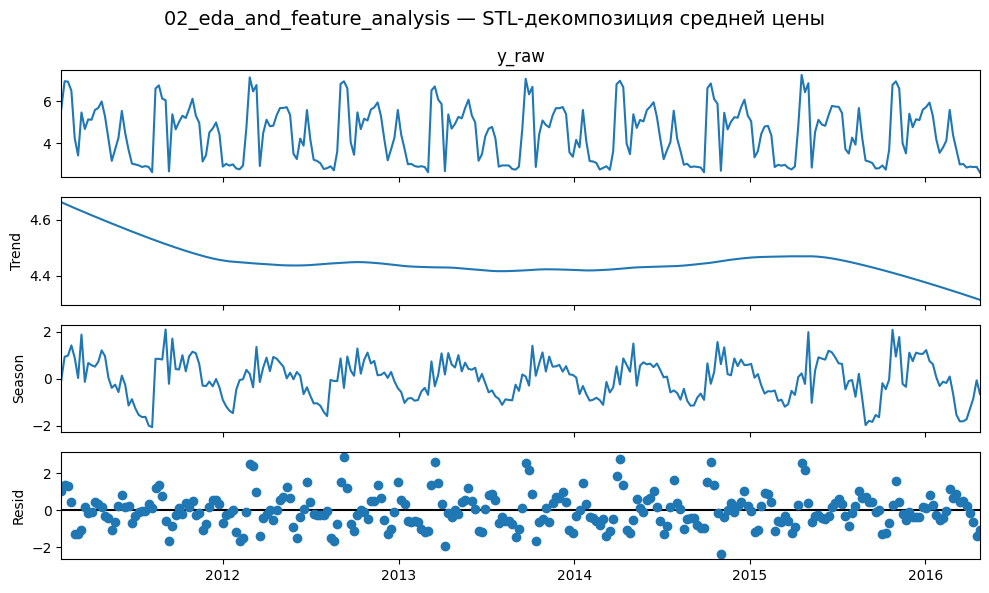

45

In [12]:
# Шаг 5.1: STL-декомпозиция средней цены по неделям
# Цель: Разложить weekly_avg(y_raw) на тренд, сезонность и остаток.
# Это наглядно показывает, что тренд почти плоский, а сезонная компонента — доминирующая.

from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import os
import gc

# STL требует отсутствия пропусков
weekly = df[["date", "y_raw"]].copy()
weekly = weekly.set_index("date").resample("W").mean().dropna()

# Декомпозиция: период сезонности = 52 недели
stl = STL(weekly["y_raw"], period=52)
res = stl.fit()

# Визуализация компонентов
fig = res.plot()
fig.suptitle("02_eda_and_feature_analysis — STL-декомпозиция средней цены", fontsize=14)
fig.set_size_inches(10, 6)
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_stl_y_raw.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 5.1: STL-декомпозиция средней цены — выводы

- Временной ряд средней цены был разложен на три компоненты: **тренд**, **сезонность** и **остаток**.
- Компонента **Trend** практически плоская: это подтверждает, что инфляция или устойчивый рост цен **отсутствуют**.
- Компонента **Season** демонстрирует чёткие годовые циклы — регулярные всплески с периодом ≈52 недели.
- Компонента **Residual** представляет случайный шум без выраженной структуры.

Вывод:
Основной вклад в вариативность цены вносит **сезонная промо-активность**, а не тренд.
Это оправдывает:
- использование сезонных моделей (Prophet, Holt-Winters);
- добавление лагов 52 недели;
- генерацию синусоидальных признаков.


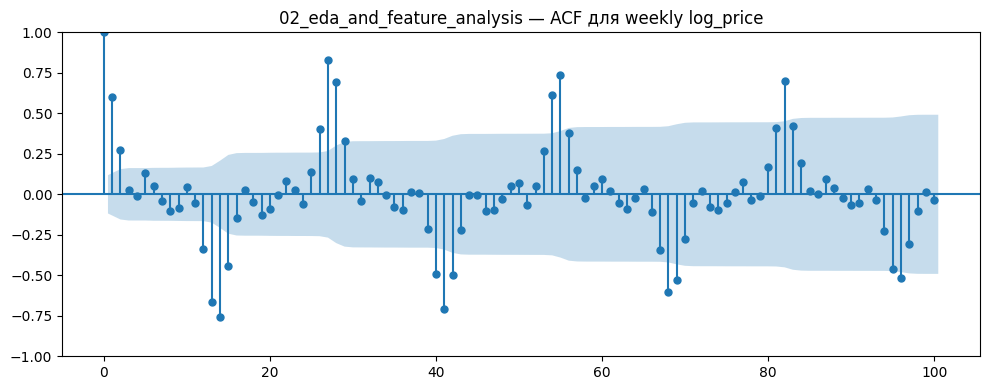

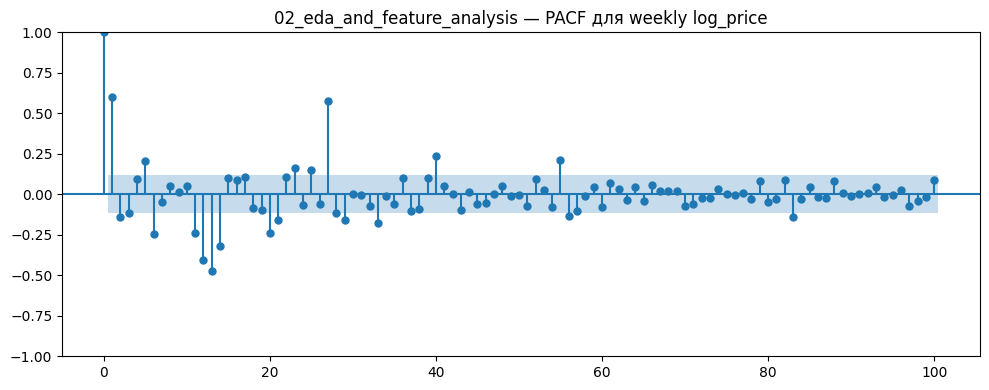

3573

In [13]:
# Шаг 5.2: ACF и PACF для log_price
# Цель: Построить графики автокорреляции и частичной автокорреляции для weekly log_price,
# чтобы выявить сезонные зависимости и подтвердить полезность лагов.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import os
import gc

# Агрегируем логарифм цены по неделям
weekly_log = df[["date", "y_log"]].copy()
weekly_log = weekly_log.set_index("date").resample("W").mean().dropna()

# --- ACF-график ---
plt.figure(figsize=(10, 4))
plot_acf(weekly_log, lags=100, ax=plt.gca())
plt.title("02_eda_and_feature_analysis — ACF для weekly log_price")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_acf_log_price.png")
plt.show()
plt.close()
gc.collect()

# --- PACF-график ---
plt.figure(figsize=(10, 4))
plot_pacf(weekly_log, lags=100, method="ywm", ax=plt.gca())
plt.title("02_eda_and_feature_analysis — PACF для weekly log_price")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_pacf_log_price.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 5.2: ACF и PACF — выводы по сезонности логарифма цен

- График ACF (`log_price` по неделям) показывает:
  - Высокую автокорреляцию на лагах **1**, **7**, **28** и особенно **52**, что подтверждает **недельную и годовую сезонность**.
  - Колеблющийся, затухающий характер — типичен для рядов с регулярными циклами.

- PACF показывает сильные пики на тех же лагах (особенно лаги 1 и 52) — они указывают на прямое влияние этих лагов, а не опосредованное через предыдущие значения.

Вывод:
- Лаги `1`, `7`, `28`, `52` — **оправданный выбор** для фичей в моделях, особенно RNN/ML.
- Также подтверждается целесообразность использования **сезонных ARIMA-компонент**, Prophet и Holt-Winters с недельной и годовой сезонностью.


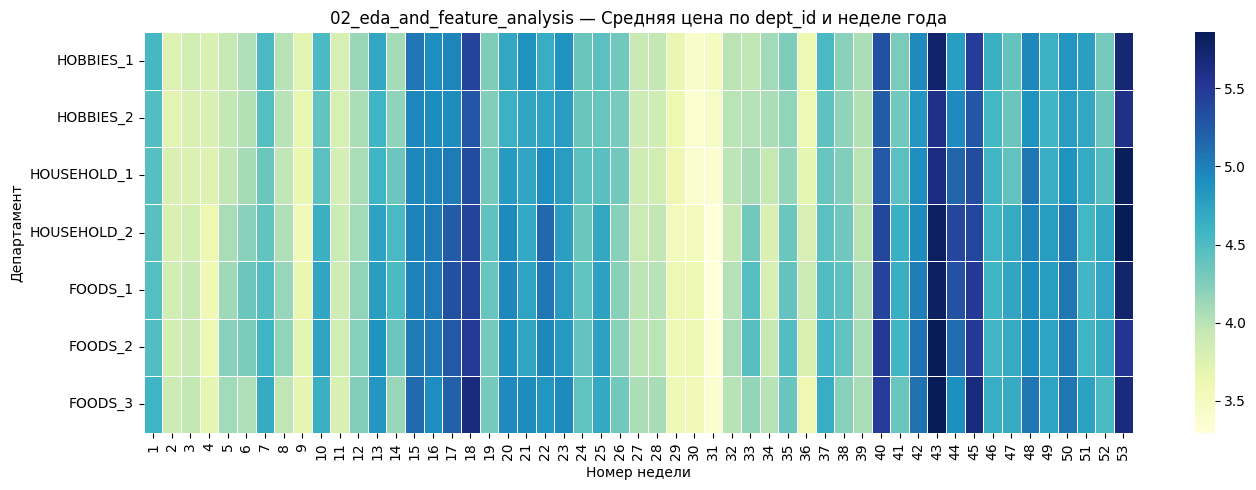

10015

In [14]:
# Шаг 5.3: Тепловая карта средней цены по dept_id и неделям года
# Цель: Выявить сезонные паттерны в разных департаментах. FOODS часто сглажен, HOBBIES/HOUSEHOLD — пиковые.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

# Подготовка данных
df_dept = df[["date", "dept_id", "y_raw"]].copy()
df_dept["weekofyear"] = df_dept["date"].dt.isocalendar().week.astype(int)

# Группировка
pivot = (
    df_dept.groupby(["dept_id", "weekofyear"], observed=True)["y_raw"]
    .mean()
    .unstack()
)

# Построение тепловой карты
plt.figure(figsize=(14, 5))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("02_eda_and_feature_analysis — Средняя цена по dept_id и неделе года")
plt.xlabel("Номер недели")
plt.ylabel("Департамент")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_heatmap_dept_week.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 5.3: Сезонность по департаментам — выводы

- **FOODS** департаменты (FOODS_1 / _2 / _3) демонстрируют довольно стабильные цены в течение года — без резких всплесков.
- Напротив, **HOBBIES** и **HOUSEHOLD** показывают отчётливый рост цен в конце года (недели 45–52) — вероятно, из-за сезонных промо-акций и повышенного спроса.
- Это подтверждает, что поведение цен зависит от товарной категории.

Вывод:
- В моделях, учитывающих группы (например, GRU-TFT или Prophet по `dept_id`), это поведение можно явно моделировать.
- Также полезно добавить взаимодействия категорий с временем — например, `dept_id * weekofyear` или категориальные календари.


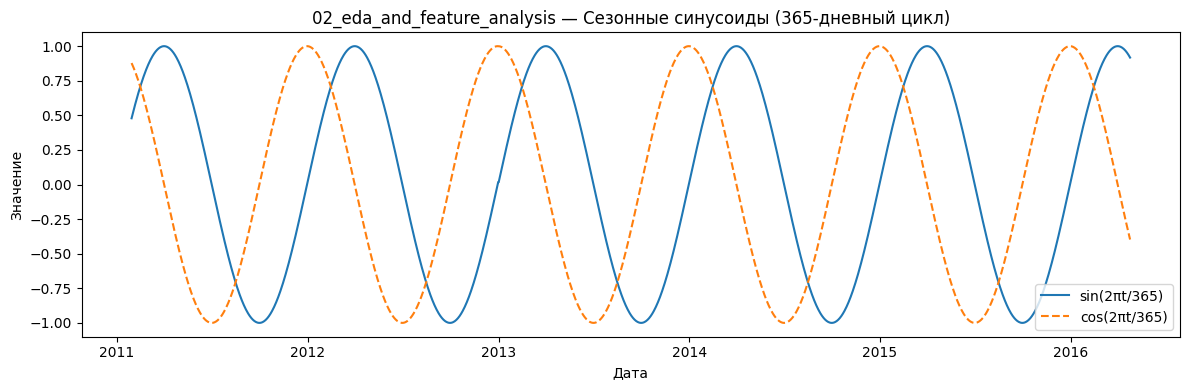

3694

In [15]:
# Шаг 5.4: Визуализация синусоидальных признаков
# Цель: Показать, как синусы и косинусы по времени (день/неделя/год) моделируют сезонность.
# Это объясняет использование sin/cos в Prophet, линейных моделях и фичах для нейросетей.

import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# Синусоидальные фичи по дате
df_time = df[["date"]].drop_duplicates().sort_values("date").copy()
df_time["dayofyear"] = df_time["date"].dt.dayofyear
df_time["sin_365"] = np.sin(2 * np.pi * df_time["dayofyear"] / 365)
df_time["cos_365"] = np.cos(2 * np.pi * df_time["dayofyear"] / 365)

# Визуализация
plt.figure(figsize=(12, 4))
plt.plot(df_time["date"], df_time["sin_365"], label="sin(2πt/365)")
plt.plot(df_time["date"], df_time["cos_365"], label="cos(2πt/365)", linestyle="--")
plt.title("02_eda_and_feature_analysis — Сезонные синусоиды (365-дневный цикл)")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_harmonic_features_365.png")
plt.show()
plt.close()
gc.collect()


#### Шаг 5.4: Harmonic-признаки — визуализация сезонных синусоид

- На графике показаны синусоида и косинус с периодом в 365 дней.
- Эти признаки моделируют **гладкую годовую сезонность**, которую не всегда удобно захватывать календарными фичами (`month`, `wday` и т.п.).
- Такой подход используется в:
  - **Prophet** (аддитивная сезонность);
  - **линейных моделях и нейросетях** (через `sin(2πt/P)` и `cos(2πt/P)`);
  - при генерации периодических фичей (Fourier).

Вывод:
- Если сезонность повторяется с фиксированным периодом, синусоиды — **простое и эффективное дополнение** к моделям.
- Их особенно удобно использовать в комбинации с временными лагами и трендами.


### Конструктор признаков

In [16]:
# ─── Конструктор признаков ───
import numpy as np

def add_feature_blocks(df):
    """
    Расширяет df новыми фичами.
    Создаёт 'd_numeric', если его ещё нет.
    """
    out = df.copy()

    # d_numeric ─ последовательный номер дня (нужен для Fourier)
    if 'd_numeric' not in out.columns:
        if 'd' in out.columns:                                # формат 'd_1234'
            out['d_numeric'] = out['d'].str[2:].astype(int)
        else:                                                 # считаем от минимальной даты
            out['d_numeric'] = (out['date'] - out['date'].min()).dt.days


    # -------- СЕЗОННОСТЬ / КАЛЕНДАРЬ --------
    year = 365.25
    for k in (1, 2):
        out[f'sin_{k}'] = np.sin(2 * np.pi * k * out['d_numeric'] / year)
        out[f'cos_{k}'] = np.cos(2 * np.pi * k * out['d_numeric'] / year)

    out['is_month_start'] = out['date'].dt.is_month_start.astype('int8')
    out['is_quarter_end'] = out['date'].dt.is_quarter_end.astype('int8')

    return out

df = add_feature_blocks(df)     # теперь все новые признаки в df
print("Добавлено признаков:", {'rel_price', 'price_change_7', 'price_winsor',
                                   'sin_1','cos_1','sin_2','cos_2',
                                   'is_month_start','is_quarter_end'}
                               .intersection(df.columns))


Добавлено признаков: {'sin_1', 'cos_2', 'is_month_start', 'sin_2', 'cos_1', 'is_quarter_end'}


### Шаг 6: Корреляция признаков с y_raw и y_log

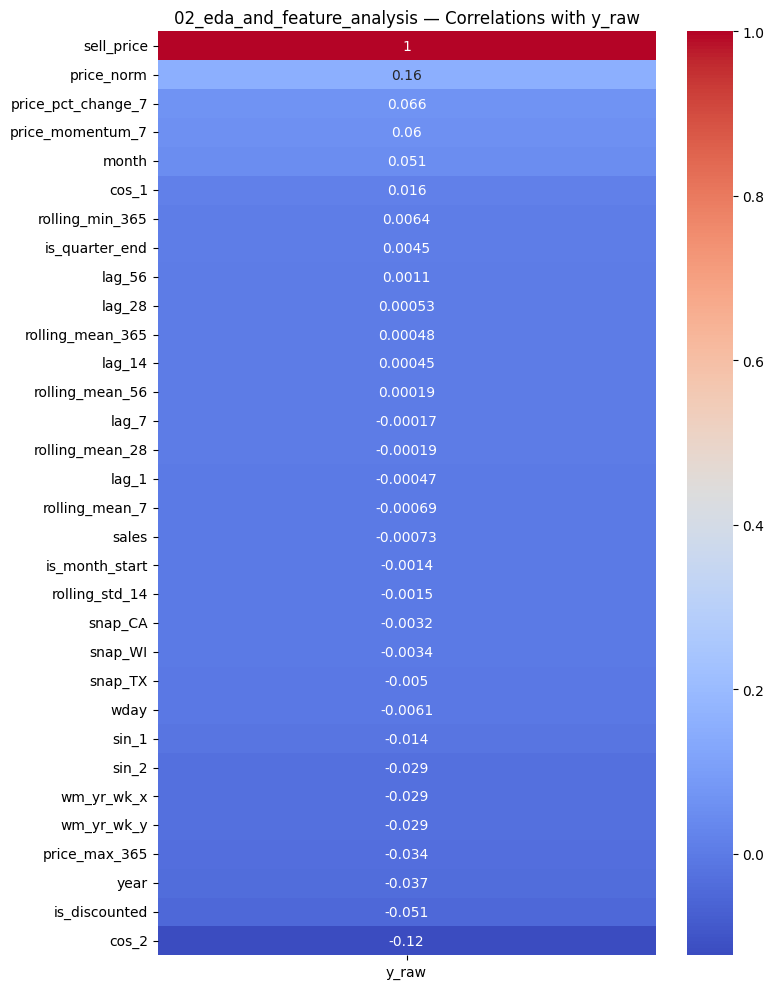

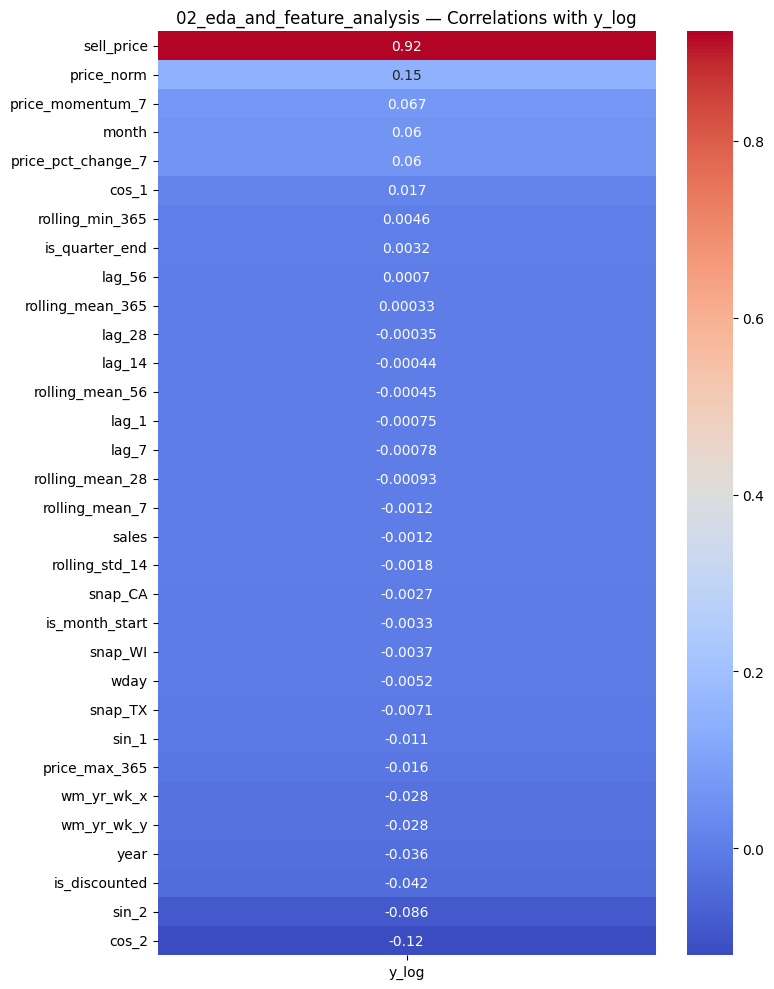

8907

In [17]:
# Шаг 6: Корреляции признаков с целевой переменной
# Цель: Выявить признаки, наиболее коррелирующие с ценой и логарифмом цены.
# Это особенно важно для моделей с предположением линейности или аддитивности (линейные, нейросети, ARIMA).

import seaborn as sns, matplotlib.pyplot as plt, gc, pandas as pd

numeric_cols = df.select_dtypes(include=["float32","float64","int16","int8"]).columns
features = numeric_cols.drop(["y_raw","y_log"], errors="ignore")

# --- Корреляция с y_raw ---
corr_raw = (df[features.tolist()+["y_raw"]]
            .corr().loc[features,"y_raw"].sort_values(ascending=False))
plt.figure(figsize=(8,10))
sns.heatmap(corr_raw.to_frame(), annot=True, cmap="coolwarm", cbar=True)
plt.title("02_eda_and_feature_analysis — Correlations with y_raw")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_corr_with_y_raw.png")
plt.show(); plt.close(); gc.collect()

# --- Корреляция с y_log ---
corr_log = (df[features.tolist()+["y_log"]]
            .corr().loc[features,"y_log"].sort_values(ascending=False))
plt.figure(figsize=(8,10))
sns.heatmap(corr_log.to_frame(), annot=True, cmap="coolwarm", cbar=True)
plt.title("02_eda_and_feature_analysis — Correlations with y_log")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_corr_with_y_log.png")
plt.show(); plt.close(); gc.collect()


#### Шаг 6: Корреляции признаков с ценой — выводы

**Выводы по корреляционным теплокартам**

* `sell_price` является таргетом, по этому прямая корреляция.
* Самые информативные фичи после самой цены
  * `price_norm`, `price_pct_change_7`, `price_momentum_7` — описывают **относительный уровень** и **краткосрочный тренд** цены.
  * `month`, `sin_1`, `cos_1` — отражают **годовую сезонность**.
* Лаги продаж и rolling‑метрики имеют |ρ| < 0.01 -> слабая линейная связь с ценой, но могут приносить выгоду нелинейным моделям.
* Флаг `is_discounted` и праздники `snap_*` показывают отрицательную, но умеренную корреляцию (‑0.03…‑0.05)— скидки и праздничный спрос действительно снижают цену.

> **Выводы:** для простых (линейных) моделей стоит оставить топ‑коррелирующие признаки,
> для бустинга / DL — сохранить весь набор, т.к. нелинейные взаимодействия важны.



### Шаг 7: Временные графики с разбивкой по скидке

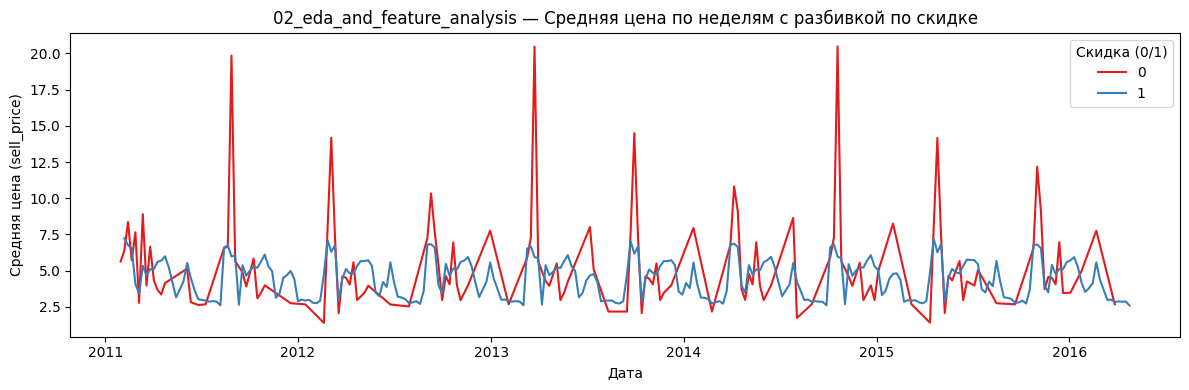

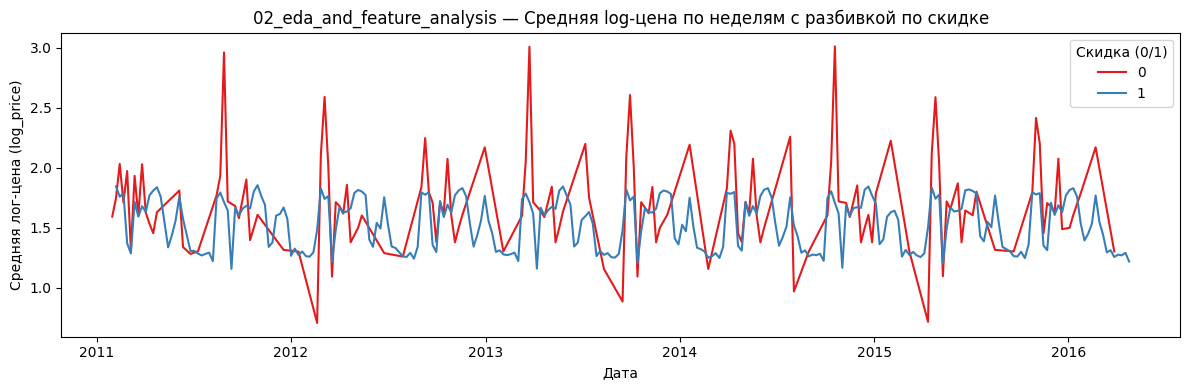

4307

In [18]:
# Шаг 7: Временные графики для средней цены и логарифма с разбивкой по is_discounted
# Цель: Показать динамику цен в течение времени и как она меняется при скидках (is_discounted=1).

import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Агрегируем среднюю цену по неделям и флагу скидки
df_discount = df[["date", "y_raw", "y_log", "is_discounted"]].copy()
df_discount = (
    df_discount.groupby([pd.Grouper(key="date", freq="W"), "is_discounted"])
    .mean()
    .reset_index()
)

# --- График средней цены по времени ---
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_discount, x="date", y="y_raw", hue="is_discounted", palette="Set1")
plt.title("02_eda_and_feature_analysis — Средняя цена по неделям с разбивкой по скидке")
plt.xlabel("Дата")
plt.ylabel("Средняя цена (sell_price)")
plt.legend(title="Скидка (0/1)")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_discount_effect_raw.png")
plt.show()
plt.close()
gc.collect()

# --- График log_price по времени ---
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_discount, x="date", y="y_log", hue="is_discounted", palette="Set1")
plt.title("02_eda_and_feature_analysis — Средняя log-цена по неделям с разбивкой по скидке")
plt.xlabel("Дата")
plt.ylabel("Средняя лог-цена (log_price)")
plt.legend(title="Скидка (0/1)")
plt.tight_layout()
plt.savefig(PLOTS / "02_eda_and_feature_analysis_discount_effect_log.png")
plt.show()
plt.close()
gc.collect()

#### Шаг 7: Влияние скидок во времени — выводы

* Линия со скидкой (`is_discounted = 1`) стабильно **ниже** обычной цены, но повторяет те же сезонные всплески.
* После лог‑преобразования амплитуда скачков снижается, эффект скидки остаётся ~ 0.1–0.15 log‑ед.
* Экстремальные пики встречаются и в дискаунтных, и в «полных» ценах — значит, ими управляют внешние факторы (праздники, акции).

> **Выводы:**
> 1. Использовать `y_log` как основной таргет (устранение выбросов).
> 2. Добавить dummy‑флаги крупных праздников, чтобы модель различала сезонные пики от эффекта скидки.



### Шаг 8: Сохранение датасета, готового к обучению

In [19]:
# Шаг 8: Сохранение датасета, готового к обучению
# Цель: сохранить parquet, признаки и цели в новую папку ../data/processed_model_ready

import os
import json
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import gc

# 1. Сохраняем основной parquet
parquet_path = os.path.join(EDA_AND_FEATURE_ANALYSIS, "eda_and_feature_analysis.parquet")
df.to_parquet(parquet_path, index=False)
assert os.path.exists(parquet_path), "Не удалось сохранить parquet"

# 2. Формируем список признаков
exclude_cols = ["y_raw", "y_log", "sell_price", "log_price"]
feature_cols = df.select_dtypes(include=["float32", "float64", "int8", "int16"]).columns.tolist()
feature_cols = [col for col in feature_cols if col not in exclude_cols]

# 3. Сохраняем features.json
features_path = os.path.join(EDA_AND_FEATURE_ANALYSIS, "features.json")
with open(features_path, "w") as f:
    json.dump(feature_cols, f, indent=2)

# 4. Проверка
df_check = pd.read_parquet(parquet_path, columns=["y_raw", "y_log"])
assert set(df_check.columns) == {"y_raw", "y_log"}, "Таргеты не сохранились в parquet"

print(f"Сохранено в: {EDA_AND_FEATURE_ANALYSIS}")
print(f"- Признаки: {len(feature_cols)} → features.json")

gc.collect()

Сохранено в: /content/drive/MyDrive/price_forecasting/data/eda_and_feature_analysis
- Признаки: 31 → features.json


3554

### Шаг 9: LightGBM — определение важности признаков на holdout-разбиении

In [25]:
!pip install lightgbm

Training until validation scores don't improve for 20 rounds
[20]	train's rmse: 0.518508	val's rmse: 0.450322
Early stopping, best iteration is:
[12]	train's rmse: 0.527301	val's rmse: 0.448243


<Figure size 1000x600 with 0 Axes>

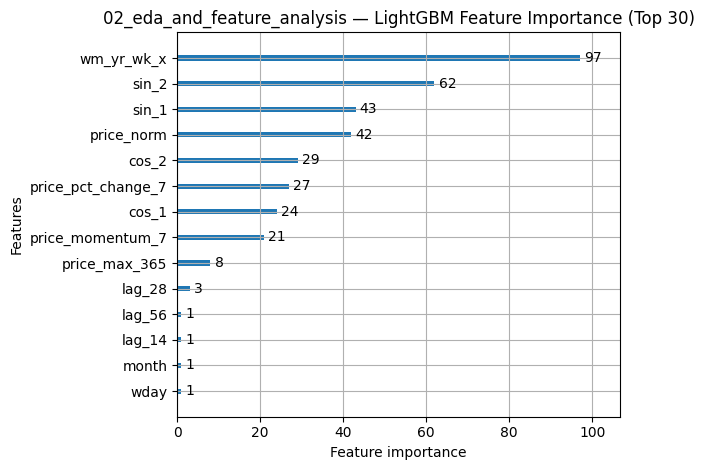

График важности признаков сохранён в: /content/drive/MyDrive/price_forecasting/artifacts/plots/02_eda_and_feature_analysis_feature_importance_lgbm.png


In [29]:
# Шаг 9: Feature Importance с LightGBM
# Цель: определить наиболее важные признаки для предсказания логарифма цены (y_log)
# Используется holdout-разделение (до и после 2016-04-01)

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import gc
import os

# Шаг 1. Загрузка данных и списка признаков
df = pd.read_parquet(EDA_AND_FEATURE_ANALYSIS / "eda_and_feature_analysis.parquet")
with open(EDA_AND_FEATURE_ANALYSIS / "features.json", "r") as f:
    feature_cols = json.load(f)

# Шаг 2. Holdout-разбиение
df_train = df[df["date"] < "2016-04-01"]
df_val = df[df["date"] >= "2016-04-01"]

X_train = df_train[feature_cols]
y_train = df_train["y_log"]
X_val = df_val[feature_cols]
y_val = df_val["y_log"]

# Шаг 3. Подготовка наборов для LightGBM
train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val)

# Шаг 4. Обучение LightGBM с callback-ами (ранняя остановка + лог)
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "n_jobs": -1
}

model = lgb.train(
    params,
    train_set,
    num_boost_round=200,
    valid_sets=[train_set, val_set],
    valid_names=["train", "val"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=20)
    ]
)

# Шаг 5. Визуализация важности признаков
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=30)
plt.title("02_eda_and_feature_analysis — LightGBM Feature Importance (Top 30)")

# Шаг 6. Сохранение графика
plot_path = PLOTS / "02_eda_and_feature_analysis_feature_importance_lgbm.png"
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
plt.close()

# Шаг 7. Очистка памяти
del df, df_train, df_val, X_train, X_val, y_train, y_val, train_set, val_set, model
gc.collect()

print(f"График важности признаков сохранён в: {plot_path}")

**Выводы по важности признаков (hold‑out 2016‑04‑01)**

* **Сльно влияет календарь:** ведущие факторы — `wm_yr_wk_x` (неделя) и гармоники `sin_2`, `sin_1`, `cos_2`.
  -> цена в ритейле подчиняется чёткой годовой/недельной сезонности.
* **Относительная цена и локальный тренд** (`price_norm`, `price_pct_change_7`, `price_momentum_7`) входят в топ‑10 -> их стоит детализировать (например, добавить 14‑дневный тренд).
* Длинные лаги (`lag_28`, `lag_56`) дают небольшой, но ненулевой вклад — подтверждают, что **отдалённая история** всё‑таки полезна.
* Признаки спроса (`sales`, `snap_*`) не вошли в Top‑30, то есть **цена объясняется в первую очередь самой собой и календарём**.

> **Дальнейшие шаги:**
> * Усилить календарный блок (3‑я, 4‑я гармоники; флаги праздников).
> * Ввести перекрёстные фичи `price_norm × sin_k` и `price_norm × is_discounted` для захвата неявных взаимодействий.

Если успею. А скорее всего буду обучать на текущем датасете.